In [21]:
import os
import sys
import gym
import matplotlib.pyplot as plt

import random
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform


# 상태가 입력, 큐함수가 출력인 인공신경망 생성 -> 상태에 따른 행동을 선택하기 위함
class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size, #출력이 큐함수이기 때문에 마지막 층의 크기 = 행동의 개수
                            kernel_initializer=RandomUniform(-1e-3, 1e-3)) #RandomUniform 함수를 통해 가중치 초기화

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q


# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = DQN(action_size)
        self.target_model = DQN(action_size) #타겟신경망을 사용
        self.optimizer = Adam(learning_rate=self.learning_rate)

        # 타깃 모델 초기화
        self.update_target_model() #두 모델의 가중치 값을 통일

    # 타깃 모델을 모델의 가중치로 업데이트: model로부터 가중치 값을 가져옴
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done): #리스트로 묶어 저장
        self.memory.append((state, action, reward, next_state, done)) #이 메모리를 다시 매 타임스텝마다 학습에 사용



    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min: #지속적인 탐험을 위해 epsilon-min 설정
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size) #self batch size 만큼의 샘플을 추출

        states = np.array([sample[0][0] for sample in mini_batch]) #학습을 위해 각각을 별도의 array로 만들어줌
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            # 현재 상태에 대한 모델의 큐함수
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions, self.action_size) #실제로 한 행동이 1, 나머지가 0인 원-핫 백터 생성
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1) #백터*(모델 예측) -> 오류함수에 들어갈 예측 부분 구함

            # 다음 상태에 대한 타깃 모델의 큐함수
            target_predicts = self.target_model(next_states)

            # 벨만 최적 방정식을 이용한 업데이트 타깃
            max_q = tf.reduce_max(target_predicts, axis=-1) #가장 큰 큐함수 값을 가져옴
            max_q = tf.stop_gradient(max_q)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts)) #MSE 오류함수를 구함

        # 오류함수를 줄이는 방향으로 모델 업데이트 -> 타깃 모델이 아니라 현재 모델이다!
        grads = tape.gradient(loss, model_params)
        if grads is None or all(g is None for g in grads):
          print("Gradients are None. Check the computational graph for errors.")
          return
        self.optimizer.apply_gradients(zip(grads, model_params))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode:   0 | score avg: 12.00 | memory length:   12 | epsilon: 1.0000
episode:   1 | score avg: 13.90 | memory length:   43 | epsilon: 1.0000
episode:   2 | score avg: 16.21 | memory length:   80 | epsilon: 1.0000
episode:   3 | score avg: 16.79 | memory length:  102 | epsilon: 1.0000
episode:   4 | score avg: 17.71 | memory length:  128 | epsilon: 1.0000
episode:   5 | score avg: 16.94 | memory length:  138 | epsilon: 1.0000
episode:   6 | score avg: 16.55 | memory length:  151 | epsilon: 1.0000
episode:   7 | score avg: 16.19 | memory length:  164 | epsilon: 1.0000
episode:   8 | score avg: 16.77 | memory length:  186 | epsilon: 1.0000
episode:   9 | score avg: 16.49 | memory length:  200 | epsilon: 1.0000
episode:  10 | score avg: 17.24 | memory length:  224 | epsilon: 1.0000
episode:  11 | score avg: 17.02 | memory length:  239 | epsilon: 1.0000
episode:  12 | score avg: 16.52 | memory length:  251 | epsilon: 1.0000
episode:  13 | score avg: 20.77 | memory length:  310 | epsilon:

TypeError: Model.save_weights() got an unexpected keyword argument 'save_format'

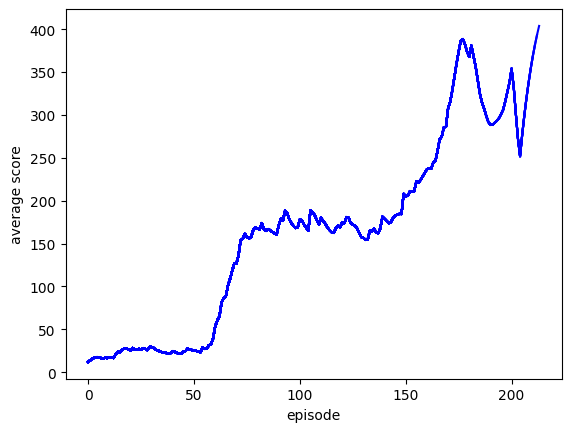

In [22]:
if __name__ == "__main__":
    # CartPole-v1 환경, 최대 타임스텝 수가 500
    env = gym.make('CartPole-v1') #환경을 env 객체로 선언   #에이전트가 학습할 예제: 카트풀   #v1: 버전1, 500 타임스텝이 최대로 플레이하는 시간인 예제
    state_size = env.observation_space.shape[0] #에이전트가 인공신경망을 만드는데 필요한 (1)상태 (2)행동의 크기를 가져옴
    action_size = env.action_space.n

    # DQN 에이전트 객체 생성
    agent = DQNAgent(state_size, action_size)
    scores, episodes = [], []
    score_avg = 0

    num_episode = 300
    for e in range(num_episode):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # 타임스텝마다 보상 0.1, 에피소드가 중간에 끝나면 -1 보상
            score += reward
            reward = 0.1 if not done or score == 500 else -1 #예제의 핵심: 쓰러지게 하는 행동이 안 좋은 것을 알고 그 행동을 하지 않는 것 -> 손실을 더 크게 함

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()
                # 에피소드마다 학습 결과 출력
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score #이동 평균
                print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(
                      e, score_avg, len(agent.memory), agent.epsilon))

                # 에피소드마다 학습 결과 그래프로 저장
                scores.append(score_avg)
                episodes.append(e)
                plt.plot(episodes, scores, 'b')
                plt.xlabel("episode")
                plt.ylabel("average score")

                # 이동 평균이 400 이상일 때 종료
                if score_avg > 400:
                    agent.model.save_weights("./save_model/model", save_format="tf")
                    sys.exit()